# FT-Transformer

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

# Load cleaned dataset
df_clean = pd.read_csv("./data/pred_maintenance_cleaned.csv")

# Split features and target
X = df_clean.drop(columns=['Machine failure'])
y = df_clean['Machine failure']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Convert to float32 numpy arrays explicitly
X_train_np = X_train.astype("float32").values
X_test_np = X_test.astype("float32").values

# Now convert to torch tensors
X_train_tensor = torch.tensor(X_train_np)
X_test_tensor = torch.tensor(X_test_np)
y_train_tensor = torch.tensor(y_train.values.astype("int64"))
y_test_tensor = torch.tensor(y_test.values.astype("int64"))

# Compute class weights for CrossEntropyLoss
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_tensor.numpy()),
    y=y_train_tensor.numpy()
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


## Model training

In [10]:
import torch.nn as nn

class FTTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.linear_in = nn.Linear(input_dim, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.linear_in(x).unsqueeze(1)  # shape: (B, 1, hidden)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.transformer(x)
        return self.head(x[:, 0])


In [11]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Prepare data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Instantiate model
model = FTTransformer(input_dim=X_train_tensor.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
import time
start_time = time.time()
epochs = 100

for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()

training_time = time.time() - start_time
print(f"Training time: {training_time:.4f} seconds")


Training time: 81.6213 seconds


## Predict and evaluate

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      1932
           1       0.14      0.97      0.24        68

    accuracy                           0.80      2000
   macro avg       0.57      0.88      0.56      2000
weighted avg       0.97      0.80      0.86      2000



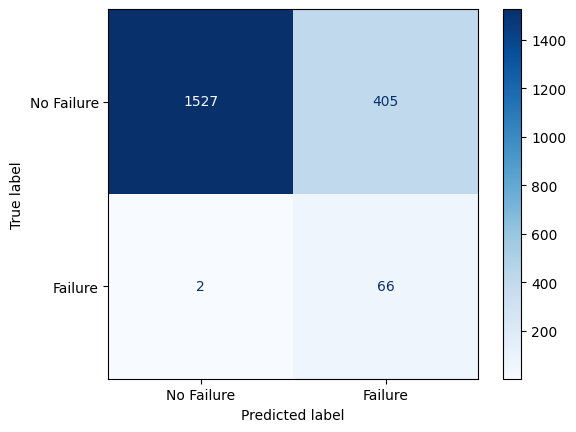

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Put model in eval mode
model.eval()

# Make predictions on test set
with torch.no_grad():
    y_logits = model(X_test_tensor.to(device))
    y_pred = torch.argmax(y_logits, dim=1).cpu().numpy()

# Evaluation report
report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test_tensor.numpy(), y_pred)

# Print report
print("Classification Report:")
print(classification_report(y_test_tensor.numpy(), y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Failure", "Failure"])
disp.plot(cmap="Blues")


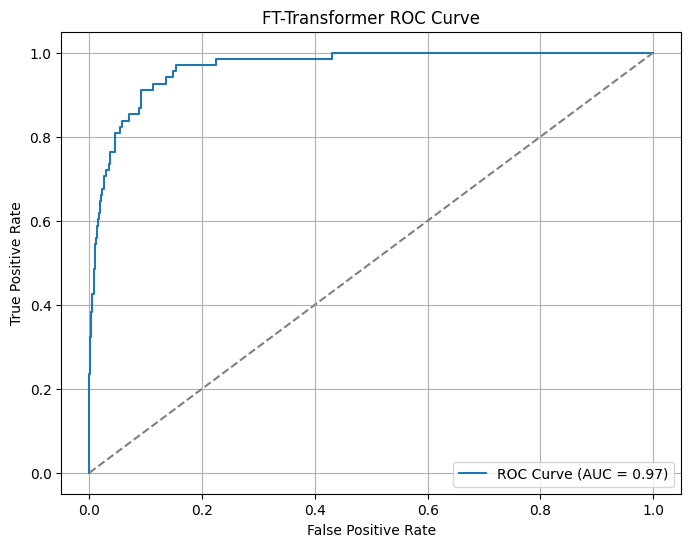

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Softmax to get probabilities
with torch.no_grad():
    y_probs = F.softmax(y_logits, dim=1)[:, 1].cpu().numpy()

# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test_tensor.numpy(), y_probs)
roc_auc = roc_auc_score(y_test_tensor.numpy(), y_probs)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("FT-Transformer ROC Curve")
plt.legend()
plt.grid()
plt.show()


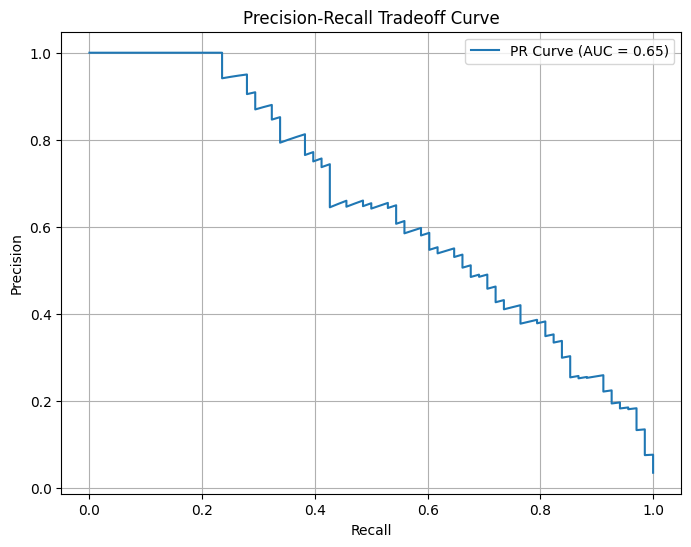

In [18]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test_tensor, y_probs)
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Tradeoff Curve")
plt.grid(True)
plt.legend()
plt.show()


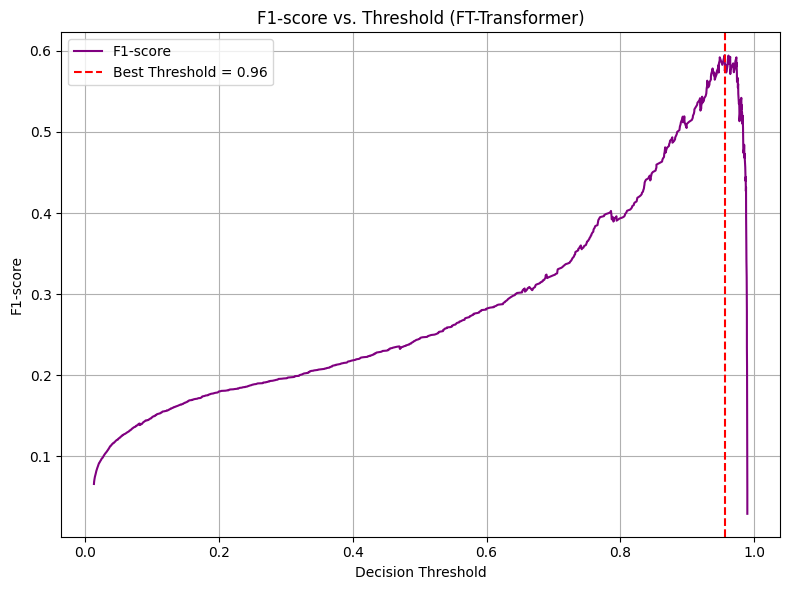

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test_tensor.numpy(), y_probs)

# Compute F1-scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Note: precision_recall_curve returns len(thresholds) = len(precision) - 1
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1-score", color="purple")
plt.xlabel("Decision Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs. Threshold (FT-Transformer)")
plt.grid(True)
plt.axvline(thresholds[np.argmax(f1_scores)], color='red', linestyle='--', label=f"Best Threshold = {thresholds[np.argmax(f1_scores)]:.2f}")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
import csv

# Select key metrics
metrics = {
    "Model": "FT-Transformer",
    "Accuracy": report["accuracy"],
    "Precision": report["1"]["precision"],
    "Recall": report["1"]["recall"],
    "F1-score": report["1"]["f1-score"],
    "Training Time (s)": training_time
}

# Output path
output_path = "./data/ftt_metrics.csv"

# Save
with open(output_path, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    writer.writeheader()
    writer.writerow(metrics)

print(f"Metrics saved to {output_path}")


Metrics saved to ./data/ftt_metrics.csv
